In [1]:
import dask_jobqueue
import socket
from dask_jobqueue import LSFCluster
import os

In [2]:
node_memory = 256
n_workers_per_node = 4
memory = '{}GB'.format(node_memory/n_workers_per_node)
notebook_name = "jag"

In [3]:
cluster = LSFCluster(cores = n_workers_per_node,processes=n_workers_per_node, memory='{}GB'.format(node_memory), header_skip=['-n ','-R','-M', '-P', '-W'], 
                     job_extra = ['-nnodes 1', '-G asccasc', '-W 00:30', '-o {}.log'.format(notebook_name), '-e {}.log'.format(notebook_name)], use_stdin=True, scheduler_options={'host': socket.gethostname()})

/p/gpfs1/haridev/software/spack/opt/spack/linux-rhel7-power9le/gcc-8.3.1/anaconda3-2021.05-ou5c3s4g5b6ac7d3ielq2ysjqrbmyvaj/envs/jupyter/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46325 instead
  warnings.warn(


In [4]:
import dask.dataframe as dd
from dask.distributed import wait, progress
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import time
from time import sleep

In [5]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.LSFCluster
Dashboard: http://192.168.66.200:46325/status,
Dashboard: http://192.168.66.200:46325/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://192.168.66.200:39777,Workers: 0
Dashboard: http://192.168.66.200:46325/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
n_workers = 16

In [7]:
cluster.scale(n_workers)

In [8]:
val = len(client.scheduler_info()["workers"])
while ((client.status == "running") and ( val< n_workers)):
    print("Waiting for workers completed {} of {}".format(val, n_workers), end="\r")
    sleep(1.0)
    val = len(client.scheduler_info()["workers"])
print("\n{} workers started".format(len(client.scheduler_info()["workers"])))

Waiting for workers completed 0 of 16
16 workers started


In [9]:
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer

In [10]:
def thread_print(string):
    print(f'{string}\n', end='')
def thread_process( num_ranks, func, start=0, list_range=[], workers=40):
    with ThreadPoolExecutor(max_workers = workers) as executor:
        if len(list_range) == 0:
            list_range = range(start, num_ranks) 
        future_gen = {executor.submit(func, rank): rank for rank in list_range}
        for future in concurrent.futures.as_completed(future_gen):
            rank = future_gen[future]
            try:
                data = future.result()
            except Exception as exc:
                thread_print('%r generated an exception: %s' % (rank, exc))
            else:
                thread_print('%r data computed' % (rank))

In [11]:
parquet_folder="/p/gpfs1/haridev/parquet/lbann-exagan-32-trace-3"

In [12]:
num_ranks = 128

In [13]:
#client.restart()

### process dataset per rank

In [14]:
ddf = dd.read_parquet("{}/*.parquet".format(parquet_folder), engine="pyarrow-dataset")

In [15]:
ddf.npartitions

128

In [16]:
#client.cancel(ddf)

In [17]:
ddf.columns

Index(['index', 'rank', 'thread_id', 'cat', 'tstart', 'tend', 'func_id',
       'level', 'arg_count', 'args_1', 'args_2', 'args_3', 'args_4', 'args_5',
       'args_6', 'args_7', 'args_8', 'args_9', 'args_10'],
      dtype='object')

In [18]:
#ddf[0].head()

In [19]:
ddf = ddf[ddf['level'] == 0]
#ddf = ddf.persist()

In [20]:
io_ddf = ddf[ddf['cat'].isin([0,1,3])]
exclude_dirs = [".pyc", "/usr","/g/g92/haridev/.nccl.conf"]
for directory in exclude_dirs:
    io_ddf = io_ddf[~io_ddf['args_1'].str.contains(directory)]
#io_ddf[rank] = io_ddf[rank].persist()
mpi_ddf = ddf[ddf['cat'] == 2]
#mpi_ddf[rank] = mpi_ddf[rank].persist()
trace_ddf = ddf[ddf['cat'] == 4]

In [21]:
io_ddf.columns

Index(['index', 'rank', 'thread_id', 'cat', 'tstart', 'tend', 'func_id',
       'level', 'arg_count', 'args_1', 'args_2', 'args_3', 'args_4', 'args_5',
       'args_6', 'args_7', 'args_8', 'args_9', 'args_10'],
      dtype='object')

In [22]:
open_condition = io_ddf['func_id'].str.contains("open")
mpi_condition = io_ddf['func_id'].str.contains("MPI")
read_condition = io_ddf['func_id'].isin(["read", "pread", "pread64", "readv"])
fread_condition = io_ddf['func_id'].isin(["fread"])
close_condition = io_ddf['func_id'].str.contains('close')
write_condition = io_ddf['func_id'].isin(["write", "pwrite", "pwrite64","writev"])
fwrite_condition = io_ddf['func_id'].isin(["fwrite"])
readdir_condition = io_ddf['func_id'].isin(["readdir"])

In [23]:
io_ddf['filename'] = ""
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & ~mpi_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & mpi_condition, io_ddf['args_2'])
io_ddf['filename'] = io_ddf['filename'].mask(close_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(read_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fread_condition, io_ddf['args_4'])
io_ddf['filename'] = io_ddf['filename'].mask(write_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fwrite_condition, io_ddf['args_4'])

In [24]:
io_ddf['size'] = "0"
io_ddf['count'] = "1"
io_ddf['size'] = io_ddf['size'].mask(read_condition , io_ddf['args_3'])
io_ddf['size'] = io_ddf['size'].mask(fread_condition, io_ddf['args_3'])
io_ddf['count'] = io_ddf['count'].mask(fread_condition, io_ddf['args_2'])
io_ddf['size'] = io_ddf['size'].mask(write_condition, io_ddf['args_3'])
io_ddf['size'] = io_ddf['size'].mask(fwrite_condition, io_ddf['args_3'])
io_ddf['count'] = io_ddf['count'].mask(fwrite_condition, io_ddf['args_2'])

In [25]:
io_ddf['size'] = io_ddf['size'].mask(readdir_condition , "0")
io_ddf['count'] = io_ddf['count'].mask(readdir_condition , "1")

In [26]:
#dd.compute(io_ddf['size'].unique(),io_ddf['count'].unique())

In [27]:
io_ddf = io_ddf.astype({'size': 'int32','count': 'int32'})

In [28]:
io_ddf['size'] = io_ddf['size'] * io_ddf['count']

In [29]:
io_ddf = io_ddf.persist()

In [30]:
wait(io_ddf)

DoneAndNotDoneFutures(done={<Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-51600c26084dc2bcc167a22790ad9c1b', 46)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-51600c26084dc2bcc167a22790ad9c1b', 102)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-51600c26084dc2bcc167a22790ad9c1b', 15)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-51600c26084dc2bcc167a22790ad9c1b', 79)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-51600c26084dc2bcc167a22790ad9c1b', 4)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-51600c26084dc2bcc167a22790ad9c1b', 68)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-51600c26084dc2bcc167a22790ad9c1b', 6)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-51600c26084dc2bcc167a22790ad9c1b', 29)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-51600c26084dc2bcc167a22790ad9c1b'

In [31]:
filenames = dd.compute(io_ddf['filename'].unique())

In [32]:
filenames = filenames[0].to_numpy()

In [33]:
for filename in filenames:
    print(filename)


%p
/p/gpfs1/haridev/software/lbann/applications/physics/cosmology/ExaGAN/20210908_122541_lbann_cosmo3DGAN/experiment.prototext
/collab/usr/gapps/python/build/spack-coralea.3/opt/spack/linux-rhel7-ppc64le/gcc-4.9.3/py-packaging-17.1-ynqnwxc5jorjislnkc7tw6viegxtkkbw/lib/python3.7/site-packages/packaging-17.1-py3.7.egg
/p/gpfs1/haridev/software/lbann/applications/physics/cosmology/ExaGAN


In [34]:
relevant_filenames = [k for k in filenames if '/p/gpfs1' in k]
print(relevant_filenames)

['/p/gpfs1/haridev/software/lbann/applications/physics/cosmology/ExaGAN/20210908_122541_lbann_cosmo3DGAN/experiment.prototext', '/p/gpfs1/haridev/software/lbann/applications/physics/cosmology/ExaGAN']


In [35]:
file_df = io_ddf[io_ddf['filename'].isin(relevant_filenames)][['rank','filename','size', 'tstart', 'tend']].compute()

In [36]:
file_df['bandwidth'] = file_df['size']*1.0/(file_df['tend'] - file_df['tstart'])/1024.0/1024.0

In [37]:
file_df

,rank,filename,size,tstart,tend,bandwidth
711,0,/p/gpfs1/haridev/software/lbann/applications/p...,0,21.090313,21.090349,0.000000
844,0,/p/gpfs1/haridev/software/lbann/applications/p...,8192,21.149174,21.173134,0.326063
13845,0,/p/gpfs1/haridev/software/lbann/applications/p...,8192,32.541481,32.541550,113.777778
17395,0,/p/gpfs1/haridev/software/lbann/applications/p...,8192,38.204075,38.204144,113.777778
21066,0,/p/gpfs1/haridev/software/lbann/applications/p...,8192,44.156246,44.156311,120.470588
...,...,...,...,...,...,...
21066,127,/p/gpfs1/haridev/software/lbann/applications/p...,8192,42.435043,42.435089,170.666667
26782,127,/p/gpfs1/haridev/software/lbann/applications/p...,8192,48.823280,48.823322,186.181818
31318,127,/p/gpfs1/haridev/software/lbann/applications/p...,8192,51.823044,51.823071,292.571429
31320,127,/p/gpfs1/haridev/software/lbann/applications/p...,0,51.823517,51.823536,0.000000


/p/gpfs1/haridev/software/lbann/applications/physics/cosmology/ExaGAN/20210908_122541_lbann_cosmo3DGAN/experiment.prototext


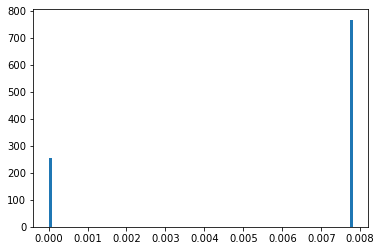

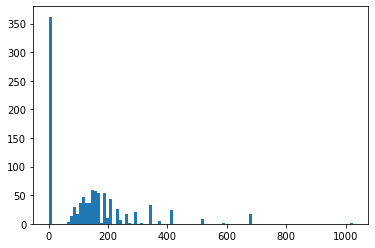

/p/gpfs1/haridev/software/lbann/applications/physics/cosmology/ExaGAN


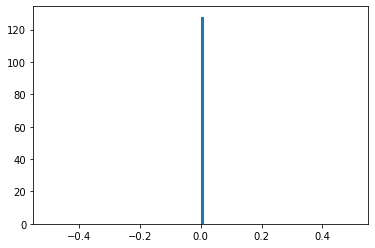

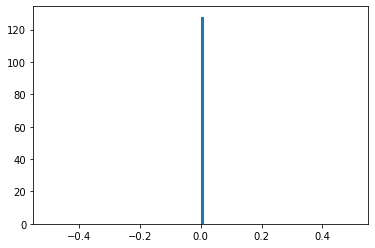

In [38]:
for filename in relevant_filenames:
    print(filename)
    file_df_temp = file_df[file_df['filename'] == filename] 
    file_sizes = file_df_temp['size'].to_numpy() / 1024.0 /1024.0
    plt.hist(file_sizes, bins=100)
    plt.show()
    plt.hist(file_df_temp['bandwidth'].to_numpy(), bins=100)
    plt.show()